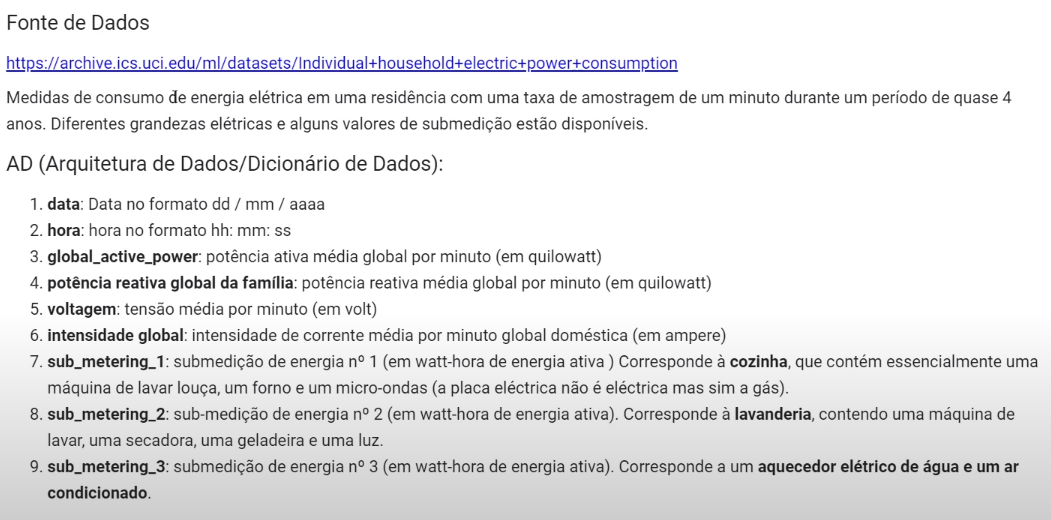

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv("datasets/household_power_consumption.csv", 
                 dtype={'Global_active_power': str, 'Global_reactive_power': str, 
                        'Voltage': str,             'Global_intensity': str,    
                        'Sub_metering_1': str,      'Sub_metering_2': str,      
                        'Sub_metering_3': str},
                 sep=";")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Date                   object
 1   Time                   object
 2   Global_active_power    object
 3   Global_reactive_power  object
 4   Voltage                object
 5   Global_intensity       object
 6   Sub_metering_1         object
 7   Sub_metering_2         object
 8   Sub_metering_3         object
dtypes: object(9)
memory usage: 142.5+ MB


In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


In [5]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

# Preprocessing

In [6]:
# correção do tipo date e junção (data hora)
df["Datetime"] = df["Date"] + " " + df["Time"]
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%d/%m/%Y %H:%M:%S")
df = df.drop(columns=["Date", "Time"])

In [7]:
# correção de tipos e padronização de nulos pela moda
for col in df.select_dtypes(include="object").columns:
    df.loc[(df[col] == "?"), [col]] = np.nan
    df[col] = df[col].astype(float)
    mode = df[col].mode()[0]
    df[col] = df[col].replace(np.nan, mode)

In [8]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Datetime                 0
dtype: int64

In [9]:
# obter valores para entrada no modelo K-means
# tudo menos a coluna de data
loc_X = df.iloc[0:, :7]

In [10]:
loc_X.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [11]:
# valores de entrada convertidos em np.array
X = loc_X.values

In [12]:
# gerando 1% dos dados totais para amostra do modelo
df_sample, sample = train_test_split(X, train_size = .01)
df_sample.shape

(20752, 7)

In [13]:
# Aplicando redução de dimensionalidade no array 
# das 7 colunas de variaveis para 2 componentes principais
pca = PCA(n_components = 2).fit_transform(df_sample)

In [14]:
# Determinando um range de Hyperparâmetro "K" do Kmeans
k_range = range(1, 12)
k_range

range(1, 12)

In [15]:
# Aplicando o modelo K-means para cada valor de K
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

Text(0.5, 1.0, 'Variância Explicada para cada valor de K')

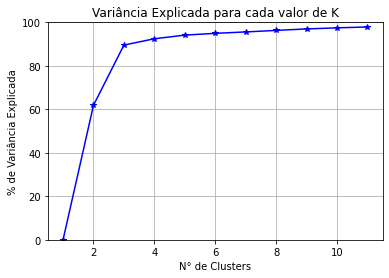

In [16]:
# Curva de Elbow

#Ajustando o centroide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculando a distancia euclidiana de cada ponto de dado para o centroide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Soma dos quadrados das distancias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total*100, "b*-")
ax.set_ylim((0, 100))
plt.grid(True)
plt.xlabel("N° de Clusters")
plt.ylabel("% de Variância Explicada")
plt.title("Variância Explicada para cada valor de K")

In [27]:
# Escolhendo um valor de K (igual a 8) para avaliaçâo de maquina preditiva

# criando um modelo com k = 8
model_v1 = KMeans(n_clusters=8)
model_v1.fit(pca)

KMeans()

In [28]:
# Obtendo os valores minimos e maximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = model_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

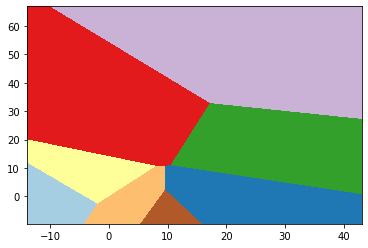

In [29]:
# Plot ds areas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(
           Z,
           interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto',
           origin='lower'
          );

In [30]:
# Metrica de avaliaçao para Clusterização
# The best value is 1 and the worst value is -1
?silhouette_score

In [31]:
# Silhouette_score
labels = model_v1.labels_

silhouette_score(pca, labels, metric='euclidean')

0.6605297827383362

In [38]:
# Marcando os clusters da Maquina Preditiva Final

# Lista de nomes de colunas
names = loc_X.columns.tolist()

# Incluindo o n° do cluster na base de clientes
cluster_map = pd.DataFrame(df_sample, columns=names)
cluster_map["cluster"] = model_v1.labels_

In [41]:
cluster_map.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,0.218,0.000,241.18,1.0,0.0,0.0,0.0,0
1,2.982,0.378,234.99,12.8,0.0,1.0,29.0,1
2,2.706,0.116,238.12,11.4,0.0,0.0,0.0,6
3,1.644,0.266,243.87,6.8,0.0,1.0,19.0,7
4,2.360,0.060,238.52,9.8,0.0,0.0,0.0,6


In [40]:
cluster_map.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
cluster                    int32
dtype: object

In [43]:
cluster_map.groupby("cluster")["Global_active_power"].mean().rename("Mean_GAP").reset_index()

,cluster,Mean_GAP
0,0,0.373361
1,1,3.022002
2,2,4.128422
3,3,3.014652
4,4,1.082347
5,5,5.799312
6,6,1.599073
7,7,1.660699


In [ ]:
# Conclusão: Grupo 5 tem maior consumo de energia dentre os 8 grupos
#            Grupo 0 tem menor consumo, assim, possivel falha na transmissão de energia?